<div class="title" style="text-align:center; padding:15px; color: #286fee">
    <h1 style='font-size: 2.8em; letter-spacing:2px;'>Prétraitement de données texte</h1>  
</div>   
<hr>

#### [I - Préparation des données](#1)
#### [II - Prétraitement du texte](#2)
#### [III - Visualisations / Word Clouds](#3)
#### [IV - Bag-of-Words / Word2Vec ](#4)
#### [V - BERT ( plantage )](#5)

<br>     

### Imports

In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install nltk
# !pip install wordcloud
# !pip install scikit-learn
# !pip install umap-learn
# !pip install -U gensim
# !pip install umap-learn

In [2]:
import pandas as pd
import re
import numpy as np
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm, metrics, cluster, manifold, decomposition
from gensim.models import Word2Vec
from umap import UMAP

### Chargement des données

In [3]:
df_full = pd.read_csv("data/cleaned.csv")
df_full.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,"[""http://img6a.flixcart.com/image/curtain/q/8/...",False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,"[""http://img6a.flixcart.com/image/bath-towel/z...",False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,"[""http://img5a.flixcart.com/image/bath-towel/a...",False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,"[""http://img6a.flixcart.com/image/bedsheet/d/r...",False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,"[""http://img6a.flixcart.com/image/bedsheet/w/q...",False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
# Select the most interesting columns
df = df_full[['uniq_id','product_name','product_category_tree','description']].copy()
df

,uniq_id,product_name,product_category_tree,description
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...
1046,fd6cbcc22efb6b761bd564c28928483c,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047,5912e037d12774bb73a2048f35a00009,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Medium Vinyl Sticker Sticker fo...


 <a id="1"></a>
 <div>
    <h2 style="font-size:2em; color: #286fee;text-decoration:underline; letter-spacing:1px">I - Préparation (nettoyage) des données</h2>
 </div>

In [5]:
df.info()
print(f"\nIl y a {df.isna().sum().sum()} valeurs manquantes")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   uniq_id                1050 non-null   object
 1   product_name           1050 non-null   object
 2   product_category_tree  1050 non-null   object
 3   description            1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB

Il y a 0 valeurs manquantes


In [6]:
initial_length = len(df)
df.drop_duplicates(keep='first', inplace=True)
print("Il y avait {} lignes de donnée complètement identiques à une autre ( doublon ) .".format(initial_length - len(df)))

Il y avait 0 lignes de donnée complètement identiques à une autre ( doublon ) .


### Création de colonnes de catégories

In [7]:
def create_category(tree, index : int):
    pattern = r"([\w\s&]+)(?= >>)"
    match = re.findall(pattern, tree)
    category = "unknown"
    if match:
        try : 
            category = match[index]
        except IndexError: 
            pass
    return category.lstrip() # remove the left space 

    

df["category"] = df["product_category_tree"].apply( lambda x : create_category(x,0) )
df["sub_category_1"] = df["product_category_tree"].apply( lambda x : create_category(x,1) )
df["sub_category_2"] = df["product_category_tree"].apply( lambda x : create_category(x,2) )
df.drop(columns='product_category_tree', inplace = True)
df.head()

,uniq_id,product_name,description,category,sub_category_1,sub_category_2
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,Baby Bath Towels
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,Bedsheets
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,Bedsheets


In [8]:
def get_unique_count(cat):
    unique, counts = np.unique(cat, return_counts=True)
    total_cat = len(unique)

    for index,cat in enumerate(unique):
        print(cat, ': ',counts[index])
    print(f"\nTotal Catégories : {total_cat}")
    return total_cat


In [9]:
# Print main categories
nb_cat = get_unique_count(df.category)

Baby Care :  150
Beauty and Personal Care :  150
Computers :  150
Home Decor & Festive Needs :  150
Home Furnishing :  150
Kitchen & Dining :  150
Watches :  150

Total Catégories : 7


In [10]:
# Print sub categories 1 
nb_cat_2 = get_unique_count(df.sub_category_1)

Baby & Kids Gifts :  15
Baby Bath & Skin :  14
Baby Bedding :  15
Baby Grooming :  4
Bar & Glassware :  8
Bath Linen :  21
Bath and Spa :  7
Beauty Accessories :  1
Bed Linen :  65
Body and Skin Care :  15
Candles & Fragrances :  1
Clocks :  1
Coffee Mugs :  74
Combos and Kits :  24
Computer Components :  2
Computer Peripherals :  4
Consumables & Disposables :  1
Containers & Bottles :  13
Cookware :  27
Curtains & Accessories :  19
Decorative Lighting & Lamps :  14
Diapering & Potty Training :  7
Dinnerware & Crockery :  1
Eye Care :  2
Feeding & Nursing :  8
Floor Coverings :  6
Fragrances :  65
Furniture & Furnishings :  2
Garden & Leisure :  1
Hair Care :  9
Health Care :  7
Housekeeping & Laundry :  1
Infant Wear :  84
JMD Home Furnishing :  1
Kitchen & Dining Linen :  14
Kitchen Tools :  14
Laptop Accessories :  87
Laptops :  2
Lighting :  7
Living :  4
Living Room Furnishing :  3
Makeup :  18
Network Components :  49
Pillows & Covers :  13
Plants & Vases :  5
Pressure Cookers & 

In [11]:
# Print sub categories 2
nb_cat_3 = get_unique_count(df.sub_category_2)

AKUP Coffee Mugs :  5
AM Creation Coffee Mugs :  1
Adapters :  9
Adino Wrist Watches :  1
Anti Dust Plugs :  1
Artificial Plants :  3
Baby Bath Towels :  11
Baby Bedsheets :  4
Baby Blankets :  8
Baby Body Wash :  2
Baby Grooming Combos :  1
Baby Massage Oils :  1
Baby Mattresses :  1
Baby Mosquito Nets :  1
Baby Shower Caps :  1
Baby Sleeping Bags :  1
Bar Accessories :  3
Bar Glasses :  5
Bath Mats :  1
Bath and Spa Accessories :  3
Batteries :  22
Bedsheets :  3
Bharatcraft Showpiece :  1
Bibs & Hankies :  2
Body and Essential Oils :  3
Boreal Baby Grooming :  1
Bottles & Accessories :  1
Bottles & Sippers :  10
Bowls :  1
Brillare Science Combos and Kits :  1
Bulbs :  7
CPU :  1
Carpets & Rugs :  6
Cases & Covers :  1
Casserole & Sets :  1
Changing Tables :  1
Choppers & Peelers :  1
Cleaning Kits :  1
Clocks :  3
Clothes :  84
Coasters :  1
Combo & kits :  1
Computer Accessories Combos :  11
Conditioners :  4
Containers & Jars :  1
Contemporary :  3
Cotton Buds :  1
Cups & Saucers

### Target encoding

In [12]:
# Define the target to encode
target = df['category']

le = LabelEncoder()
df['target_encoded'] = le.fit_transform(target)
df.head(10)

,uniq_id,product_name,description,category,sub_category_1,sub_category_2,target_encoded
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,Curtains & Accessories,Curtains,4
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,Bed Linen,Bedsheets,4
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,Bed Linen,Bedsheets,4
5,893aa5ed55f7cff2eccea7758d7a86bd,Maserati Time R8851116001 Analog Watch - For ...,Maserati Time R8851116001 Analog Watch - For ...,Watches,Wrist Watches,unknown,6
6,f355cc1ccb08bd0d283ed979b7ee7515,"Camerii WM64 Elegance Analog Watch - For Men,...","Camerii WM64 Elegance Analog Watch - For Men,...",Watches,Wrist Watches,unknown,6
7,dd0e3470a7e6ed76fd69c2da27721041,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,Watches,Wrist Watches,unknown,6
8,41384da51732c0b4df3de8f395714fbb,"Alfajr WY16B Youth Digital Watch - For Men, Boys","Alfajr WY16B Youth Digital Watch - For Men, B...",Watches,Wrist Watches,unknown,6
9,710ed5f2393a4b9e8823aa0029f71f93,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,Watches,Wrist Watches,unknown,6


 <a id="2"></a>
 <div>
    <h2 style="font-size:2em; color: #286fee;text-decoration:underline; letter-spacing:1px">II - Prétraitement du texte</h2>
 </div>

In [13]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation, multiples spaces
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    return text

def remove_stopwords(text):
    more_stopwords = ['im','flipkartcom','genuine','shipping','products','free','cash','delivery','day','replacement'\
                     ,'rs','price','prices','guarantee','package','online']
    stop_words = set(stopwords.words('english') + more_stopwords)    
    # Remove stop stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Remove one letters words
    text = ' '.join(word for word in text.split(' ') if len(word) > 1)
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(text) 

def stemm_text(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(text)    

def tokenize(text):
    words = word_tokenize(text)
    return words

def preprocessing(series, lemmatize = False):
    clean_series = series.map(clean_text)
    clean_series = clean_series.map(remove_stopwords)
    if lemmatize : 
        clean_series = clean_series.map(lemmatize_text)
    else : 
        clean_series = clean_series.map(stemm_text)
    return clean_series

    

### Prétraitement du nom du produit

In [14]:
df['product_name_cleaned'] = preprocessing(df['product_name'], lemmatize=False)
for i in range(10) :
    print('===== Avant =====\n',df['product_name'].iloc[i])
    print('===== Après =====\n',df['product_name_cleaned'].iloc[i])
    print('')

===== Avant =====
 Elegance Polyester Multicolor Abstract Eyelet Door Curtain
===== Après =====
 elegance polyester multicolor abstract eyelet door curtain

===== Avant =====
 Sathiyas Cotton Bath Towel
===== Après =====
 sathiyas cotton bath towel

===== Avant =====
 Eurospa Cotton Terry Face Towel Set
===== Après =====
 eurospa cotton terry face towel set

===== Avant =====
 SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet
===== Après =====
 santosh royal fashion cotton printed king sized double bedsheet

===== Avant =====
 Jaipur Print Cotton Floral King sized Double Bedsheet
===== Après =====
 jaipur print cotton floral king sized double bedsheet

===== Avant =====
 Maserati Time R8851116001 Analog Watch  - For Boys
===== Après =====
 maserati time analog watch boy

===== Avant =====
 Camerii WM64 Elegance Analog Watch  - For Men, Boys
===== Après =====
 camerii elegance analog watch men boy

===== Avant =====
 T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys
===== 

### Prétraitement de la description

In [15]:
df['description_cleaned'] = preprocessing(df['description'], lemmatize=False)
for i in range(2) :
    print('===== Avant =====\n', df['description'].iloc[i])
    print('===== Après =====\n',df['description_cleaned'].iloc[i])
    print('')

===== Avant =====
 Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in you

### Concaténation de la description et du titre

In [16]:
# df['text'] = df['product_name'] + ' ' + df['description']
df['text'] = df['product_name_cleaned'] + ' ' + df['description_cleaned']
print(df['text'].iloc[4])
   

jaipur print cotton floral king sized double bedsheet key features jaipur print cotton floral king sized double bedsheet cottonjaipur print cotton floral king sized double bedsheet bed sheet pillow cover white nice bed sheet made cotton give comfort bed sheet hand printed bedsheet gives nice look room fast colour good quality gives bedsheet long lifespecifications jaipur print cotton floral king sized double bedsheet bed sheet pillow cover white general machine washable yes brand jaipur print type flat model name material cotton thread count model id fabric care machinewash bleach size king color white warranty waranty product manufacturing defect product exchange onle used returne origional packing dimensions flat sheet width inch cm fitted sheet width cm pillow cover width inch cm pillow cover length inch cm weight fitted sheet depth cm fitted sheet length cm flat sheet depth cm flat sheet length inch cm box number contents sales sales bed sheet pillow cov


 <a id="3"></a>
 <div>
    <h2 style="font-size:2em; color: #286fee;text-decoration:underline; letter-spacing:1px">III - Visualisations / Word Clouds</h2>
 </div>
 <p style="font-weight:bold"> La visualisation sous forme de nuage de mot, me permet de remplir ma liste de stopwords et ainsi retirer les mots qui apparaissent fréquemment mais qui semblent inutiles</p>

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

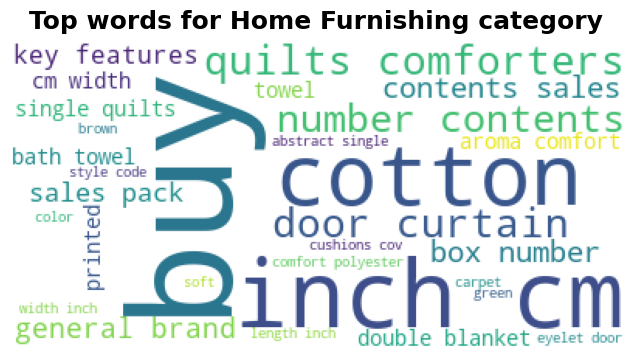

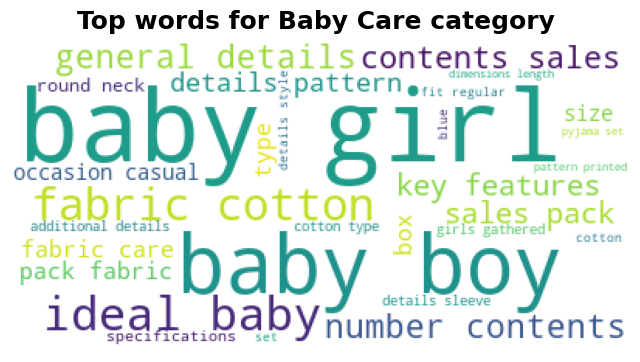

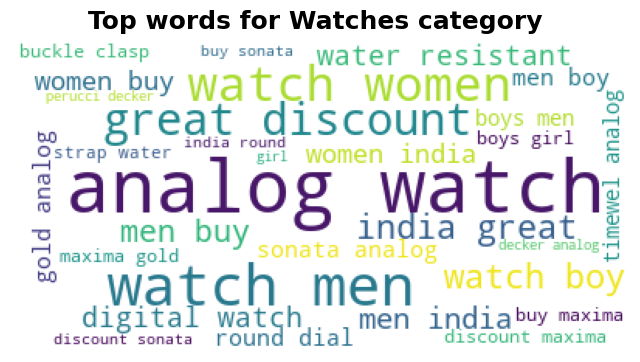

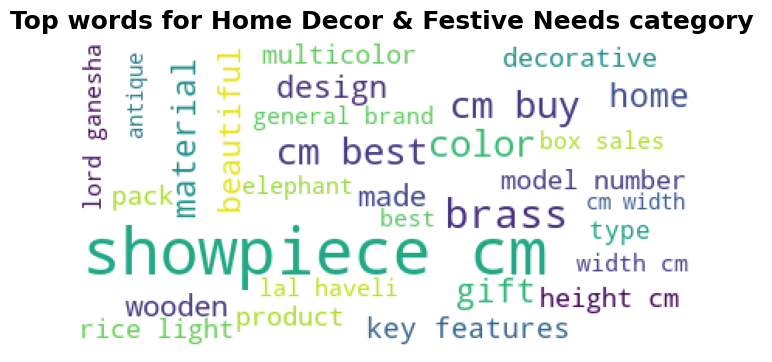

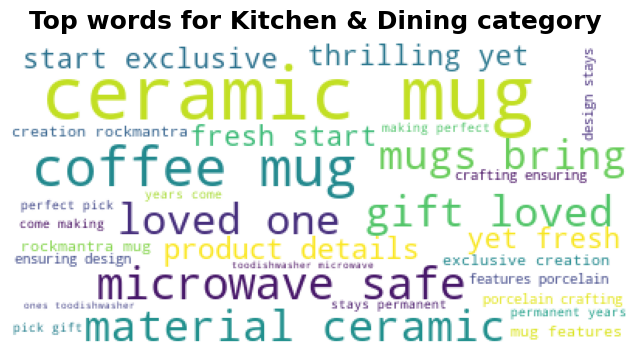

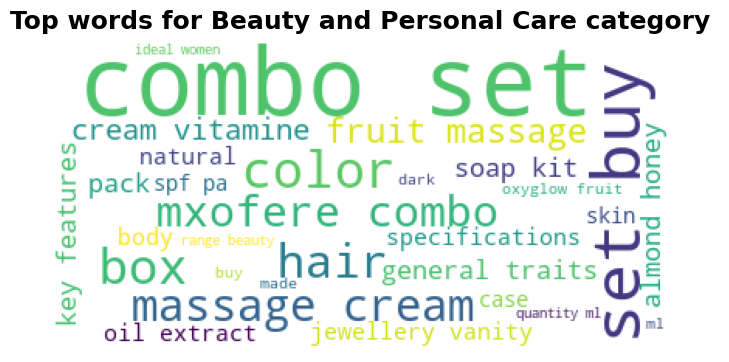

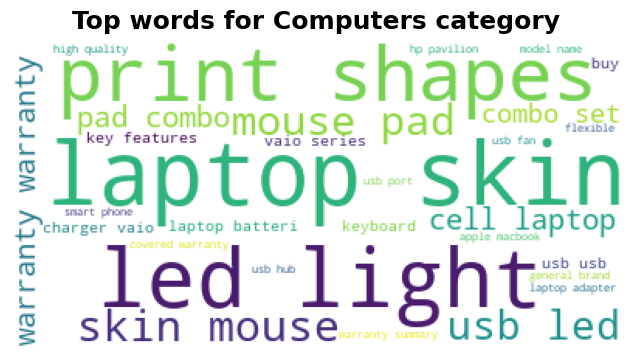

In [18]:
def display_wordcloud(df, category_name, max_words=30):
    wc = WordCloud(
        background_color='white', 
        max_words=max_words, 
        colormap="viridis"
    )
    wc.generate(' '.join(text for text in df.loc[df['category'] == category_name]['text']))
    plt.figure(figsize=(8,8))
    plt.title(f'Top words for {category_name} category ', 
              fontdict={'size': 18,  'verticalalignment': 'bottom', 'fontweight':'bold'})
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
for category in df['category'].unique():
    display_wordcloud(df, category)

 <a id="4"></a>
 <div>
    <h2 style="font-size:2em; color: #286fee;text-decoration:underline; letter-spacing:1px">IV - Bag-of-Words / WordVec : vectorisations et clusterings </h2>
 </div>

### Bag-of-words / Comptage simple

In [19]:
vectorizer = CountVectorizer(min_df=5, stop_words='english')
X_bow = vectorizer.fit_transform(df['text'])
# Normalize
X_bow = normalize(X_bow)
df_bow = pd.DataFrame(X_bow.toarray(),columns = vectorizer.get_feature_names_out())
df_bow.head()

,absorbent,abstract,ac,accessories,actual,adapt,adapter,adapters,add,addition,...,work,working,works,world,wrap,year,years,yellow,yes,youre
0,0.0,0.262071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.052414,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.154765,0.077382,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.048393,0.000000,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.050508,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.042835,0.0


### Bag-of-words / Tf-Idf

In [20]:
vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
X_bow_tfidf = vectorizer.fit_transform(df['text'])
# Normalize
X_bow_tfidf = normalize(X_bow_tfidf)
df_bow_tfidf = pd.DataFrame(X_bow.toarray(),columns = vectorizer.get_feature_names_out())
df_bow_tfidf.head()

,absorbent,abstract,ac,accessories,actual,adapt,adapter,adapters,add,addition,...,work,working,works,world,wrap,year,years,yellow,yes,youre
0,0.0,0.262071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.052414,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.154765,0.077382,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.048393,0.000000,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.050508,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.042835,0.0


### Word2Vec

In [21]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [22]:
tokenized_docs = df['text'].map(tokenize)
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)
X_w2v = vectorize(tokenized_docs, model=model)
X_w2v[0]

array([-0.10567253, -0.16231471, -0.13247417,  0.0723997 , -0.21893889,
        0.10686156,  0.2991351 ,  0.2936812 , -0.46420804,  0.04715015,
       -0.30991256,  0.08601028,  0.09048489,  0.40090498, -0.10049941,
       -0.16822717,  0.0768721 , -0.38919505, -0.41613778, -0.01526595,
       -0.11231501,  0.43007383,  0.00543014,  0.40051818,  0.2728021 ,
        0.07423824, -0.5038588 ,  0.05476614, -0.2655632 , -0.0918053 ,
        0.16878626, -0.39761922,  0.10850247, -0.03558812,  0.0153257 ,
        0.14597397,  0.33135763, -0.57425785,  0.03394361,  0.33306363,
        0.13640696,  0.11714048,  0.48419753, -0.34171727,  0.2570778 ,
       -0.11303311,  0.17080265,  0.10418634,  0.382924  , -0.07586439,
       -0.2852375 , -0.68786234,  0.03803645,  0.00472752,  0.0842629 ,
       -0.08927491, -0.06878687,  0.3587629 , -0.060937  ,  0.61128163,
       -0.01873659, -0.07250688, -0.32369727,  0.24401449,  0.3050376 ,
       -0.10573138,  0.22933282, -0.19025436, -0.03780439,  0.20

In [25]:
def reduce_dimension(X, reducer = "TSNE"):
    if reducer == "SVD":
        reducer = decomposition.TruncatedSVD()
    elif reducer == "UMAP":
        reducer = UMAP(n_components=2)
    else :
        reducer = manifold.TSNE(n_components=2, init='random', learning_rate='auto')
    reduced_X = reducer.fit_transform(X)    
    print(f"Dimensions dataset avant réduction {reducer.__class__.__name__} : ", X.shape)
    print(f"Dimensions dataset après réduction {reducer.__class__.__name__} : ", reduced_X.shape)
    return reduced_X

def make_clusters(X_reduced, true_labels):
    cls = cluster.KMeans(n_clusters=len(true_labels.unique()))
    cls.fit(X_reduced)
    print("ARI : ", metrics.adjusted_rand_score(true_labels, cls.labels_))
    return true_labels, cls.labels_
                         
def plot_clusters(true_labels, new_labels, true_labels_names, reducer_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

    # Plot true labels
    sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=true_labels, ax=ax1, palette='bright')
    ax1.set_title(f"Clusters trouvés après {reducer_name}")

    # Plot predicted labels
    sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=new_labels, ax=ax2, palette='bright')
    ax2.set_title("vraies labels")
    # Change the legend labels  
    handles, _ = ax2.get_legend_handles_labels()  
    ax2.legend(handles, true_labels_names)  
    
    plt.show()

================== Bag-of-words standard - SVD ==================
Dimensions dataset avant réduction TruncatedSVD :  (1050, 907)
Dimensions dataset après réduction TruncatedSVD :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.1535176662695961
Time elapsed : 0.332s


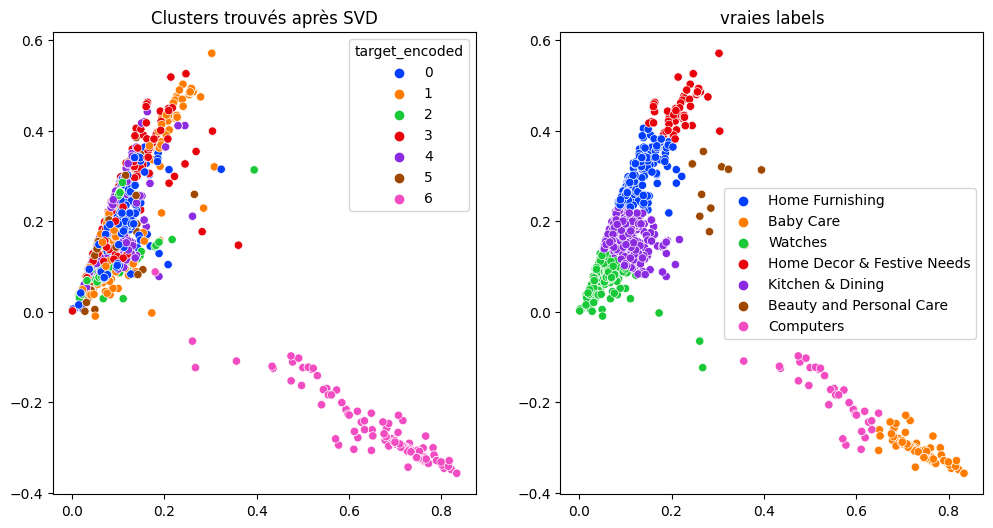


================== Bag-of-words standard - TSNE ==================
Dimensions dataset avant réduction TSNE :  (1050, 907)
Dimensions dataset après réduction TSNE :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.5158815762290536
Time elapsed : 14.379s


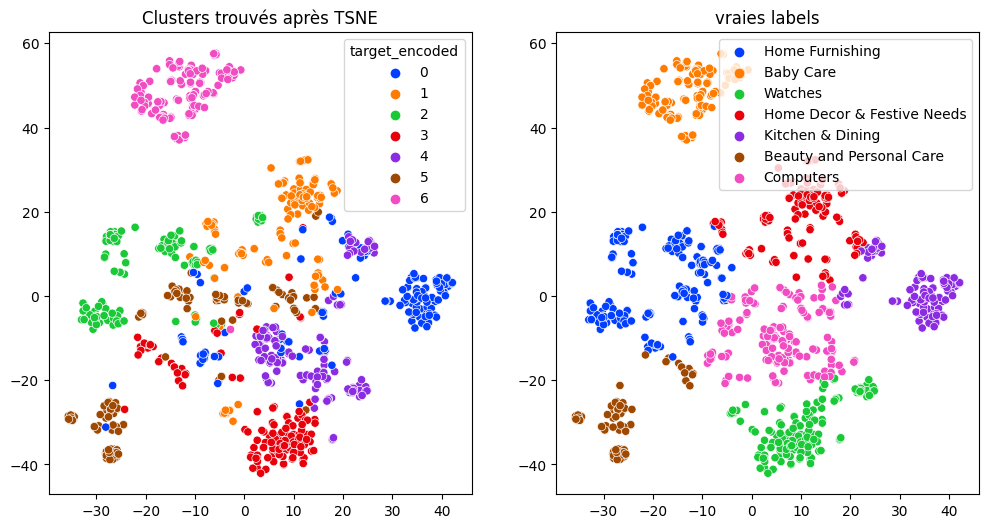


================== Bag-of-words standard - UMAP ==================
Dimensions dataset avant réduction UMAP :  (1050, 907)
Dimensions dataset après réduction UMAP :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.4071284402141348
Time elapsed : 11.759s


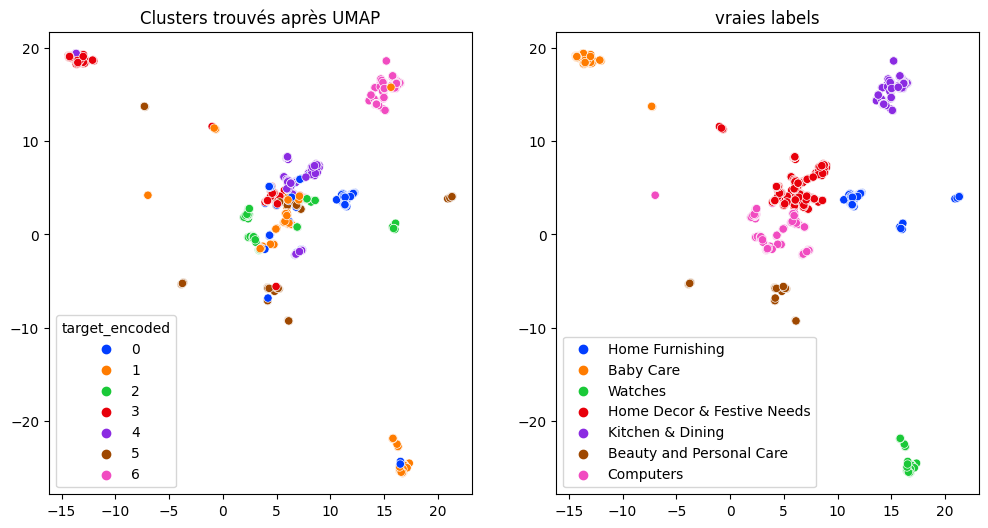


================== Bag-of-words Tf-idf - SVD ==================
Dimensions dataset avant réduction TruncatedSVD :  (1050, 907)
Dimensions dataset après réduction TruncatedSVD :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.1537743245838465
Time elapsed : 0.251s


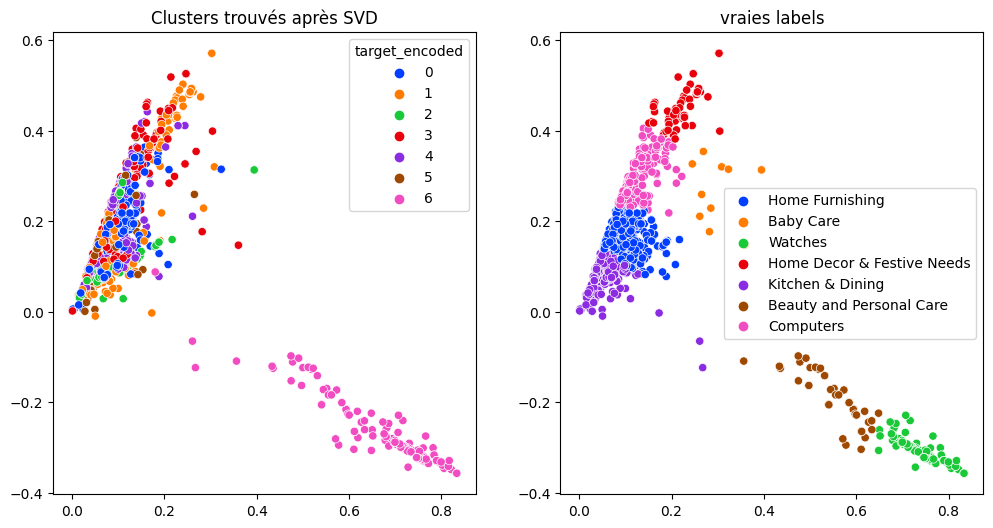


================== Bag-of-words Tf-idf - TSNE ==================
Dimensions dataset avant réduction TSNE :  (1050, 907)
Dimensions dataset après réduction TSNE :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.49495669663311004
Time elapsed : 12.928s


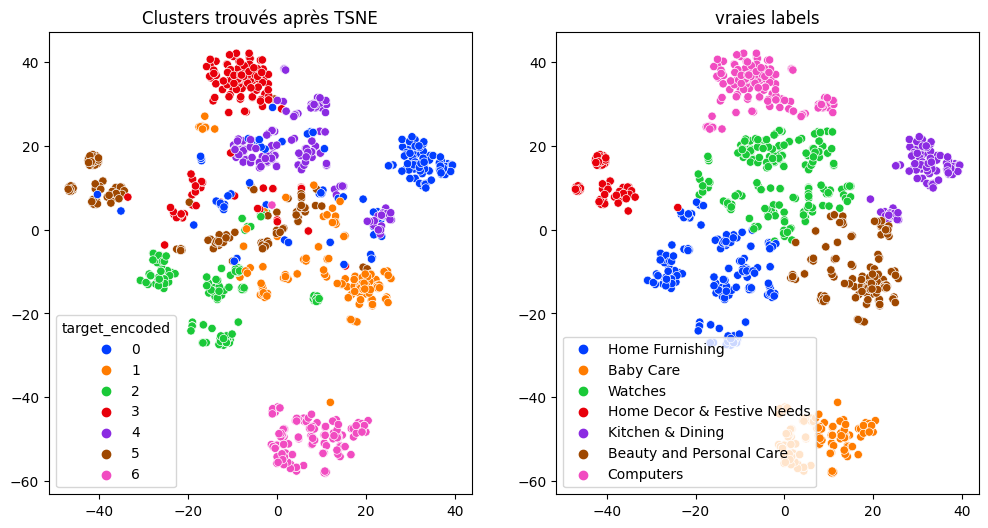


================== Bag-of-words Tf-idf - UMAP ==================
Dimensions dataset avant réduction UMAP :  (1050, 907)
Dimensions dataset après réduction UMAP :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.4814895700302637
Time elapsed : 9.816s


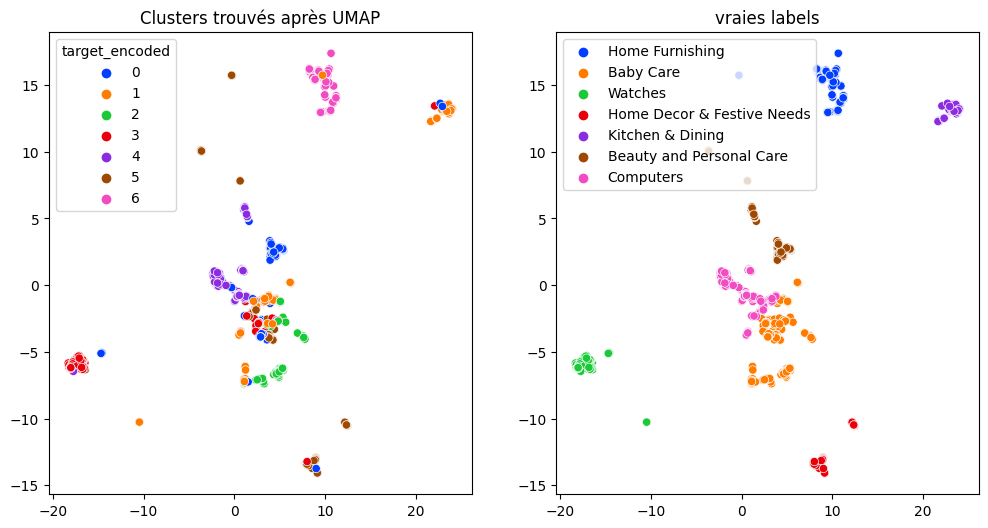


================== Word2Vec - SVD ==================
Dimensions dataset avant réduction TruncatedSVD :  (1050, 907)
Dimensions dataset après réduction TruncatedSVD :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.16669020506278215
Time elapsed : 0.26s


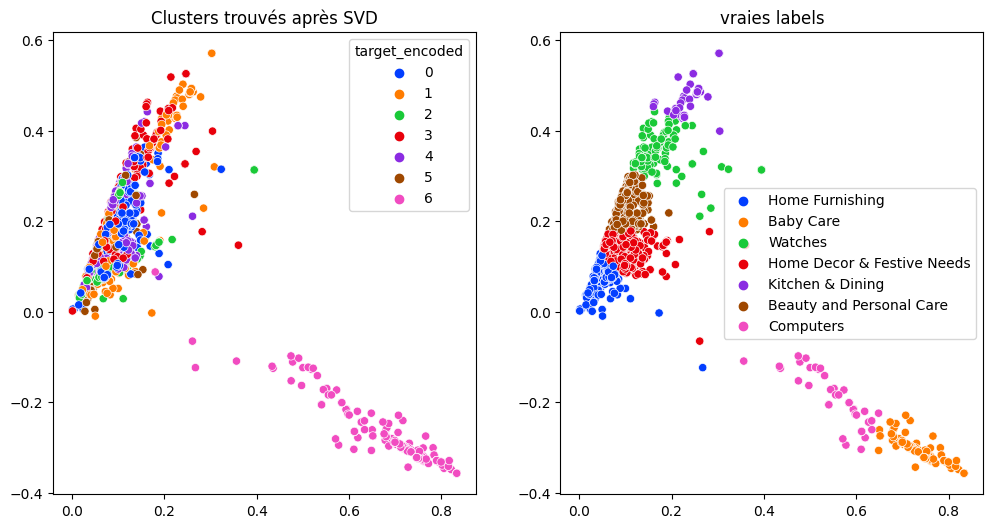


================== Word2Vec - TSNE ==================
Dimensions dataset avant réduction TSNE :  (1050, 907)
Dimensions dataset après réduction TSNE :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.48278619699064157
Time elapsed : 12.69s


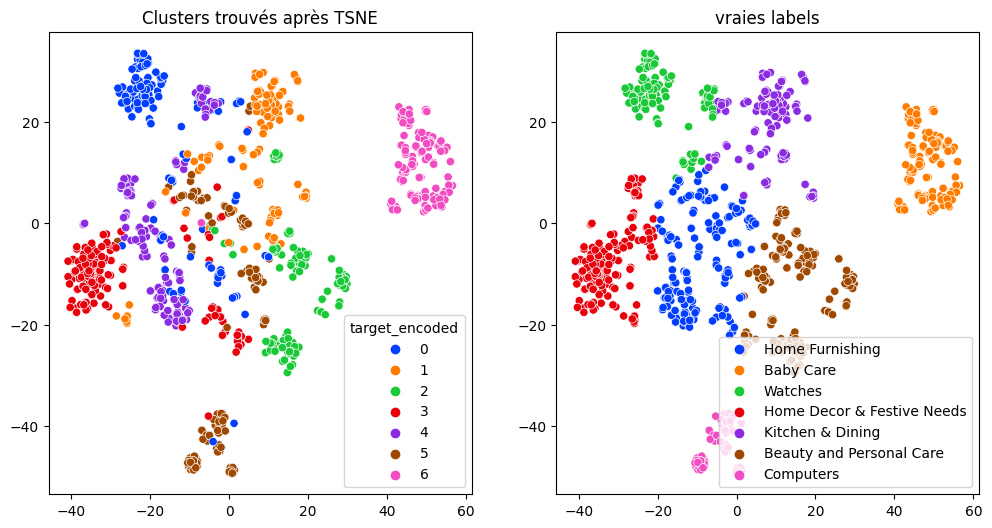


================== Word2Vec - UMAP ==================
Dimensions dataset avant réduction UMAP :  (1050, 907)
Dimensions dataset après réduction UMAP :  (1050, 2)


C:\Users\utilisateur\dev\briefs\Brief26-pretraitement\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI :  0.31628845457970417
Time elapsed : 9.631s


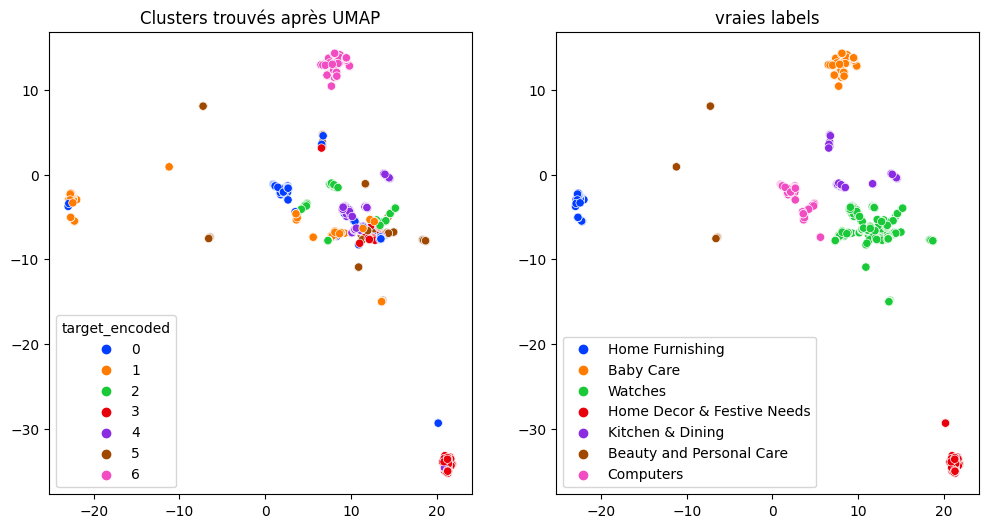

In [26]:
vectors = [X_bow, X_bow_tfidf, X_w2v]
approach_names = ["Bag-of-words standard","Bag-of-words Tf-idf","Word2Vec"]
reducers = ["SVD","TSNE","UMAP"]
label_names = df.category.unique()

for approach_name, vector in dict(zip(approach_names, vectors)).items(): 
    for reducer in reducers :
        start = time.perf_counter()
        print(f"================== {approach_name} - {reducer} ==================")
        X_reduced = reduce_dimension(X_bow,reducer=reducer)
        true_labels, predict_labels = make_clusters(X_reduced, df['target_encoded'])
        end = time.perf_counter()
        print(f"Time elapsed : {round(end-start,3)}s")        
        plot_clusters(true_labels, predict_labels, label_names, reducer)
        print('')

### FastText
Pas fait

### Glove 
Pas fait

 <a id="5"></a>
 <div>
    <h2 style="font-size:2em; color: #286fee;text-decoration:underline; letter-spacing:1px">V - BERT</h2>
 </div>
<p>BERT est un modèle de langage pré-entraîné bidirectionnel, ce qui signifie qu'il prend en compte le contexte des mots à gauche et à droite d'un mot donné pour prédire sa signification.</p>
<p>BERT utilise un réseau de neurones de type transformer, qui permet une parallélisation efficace de l'entraînement et peut capturer des relations à long terme entre les mots.</p>


<p style='font-size:1.4em'>⏰<i>  Certaines des opérations ci-dessous peuvent durer longtemps ou ne pas fonctionner ! </i></p>

In [27]:
# !pip install torch==1.13.1+cu116 -f https://download.pytorch.org/whl/cu116/torch_stable.html
# !pip install transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import gc

In [28]:
# Load the pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df.category.unique()))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [150]:
# Make sure GPU is available
if torch.cuda.is_available():
    print("Let's use the GPU bro!")
    device = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    device = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

    



def prediction_with_BERT(text_list, max_seg_length = 512):
    # Set the maximum sequence length
    max_seq_length = max_seg_length

    # Prepare the input texts
    input_ids_list = []
    attention_mask_list = []
    for index, text in enumerate(text_list):
        # Tokenize the text and add special tokens
        encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors='pt')
        input_ids = encoded_dict['input_ids']
        attention_mask = encoded_dict['attention_mask']
        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)

    # Convert the input tensors to a single tensor
    input_ids = torch.cat(input_ids_list, dim=0)
    attention_mask = torch.cat(attention_mask_list, dim=0)

    # Set the device for the tensors
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    # Move the model to the same device as the tensors
    model.to(device)

    # Pass the input through the BERT model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get the predicted labels
    logits = outputs[0]
    predicted_labels = torch.argmax(logits, dim=1)

    return predicted_labels.tolist(), logits



Let's use the GPU bro!


In [151]:
text = "This is a positive sentence."
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(tokens)
print(token_ids)

#Test
pr, log = prediction_with_BERT(['Ham','Food','Meat','Wine','Water','Drink','English','French','Spanish'],128)
print(pr)
print(log)
del pr
del log


['this', 'is', 'a', 'positive', 'sentence', '.']
[2023, 2003, 1037, 3893, 6251, 1012]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.51 GiB already allocated; 0 bytes free; 3.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

⚠️ Plante  !

In [152]:
!nvidia-smi
print(torch.cuda.memory_allocated())

Thu Apr  6 12:32:24 2023       3766597120

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.66       Driver Version: 517.66       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M2200       WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8    N/A /  N/A |   3949MiB /  4096MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                             

In [147]:
!taskkill /pid 3796
print(torch.cuda.memory_allocated())

OpÃ©ration rÃ©ussieÂ : un signal de fin a Ã©tÃ© envoyÃ© au processus de PID 3796.
3276008448


In [148]:
echantillon = 150
text_red = df[:echantillon].text.tolist()
predict_labels = prediction_with_BERT(text_red)


OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB (GPU 0; 4.00 GiB total capacity; 3.49 GiB already allocated; 0 bytes free; 3.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [155]:
true_labels = df[:echantillon]["target_encoded"]
print("ARI : ", metrics.adjusted_rand_score(true_labels, predict_labels[0]))

ARI :  0.0011949125951524373


### Universal Sentence Encoder
USE Sentence permet de classer des phrases et de les comparer sur le plan sémantique, mais aussi pour le clustering.

In [ ]:
# to do